# Initialization

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, DecimalType, IntegerType
from pyspark.sql.functions import col, month, year, isnan, desc
from functools import reduce
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /scratch/mjain3/job_30286491/matplotlib-zo500ybd because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Setting up a theme with Seaborn
sns.set_theme(style="whitegrid")

# Adjusting font scale for better readability
sns.set_context("notebook", font_scale=1.2)

In [3]:
# Create a Spark session
# spark = SparkSession.builder \
#     .appName("Yellow Taxi EDA") \
#     .getOrCreate()


# I ran this notebook successfully using 4 cores and 8GB per node in the jupyter session setup. 
# Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting.
spark = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
	.config("spark.executor.memory", "4g") \
    .config('spark.executor.instances', 6) \
	.appName("Yellow Taxi EDA") \
	.getOrCreate()

In [4]:
spark

# Importing Data

In [5]:
base_path = '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-{:02d}.parquet'
paths = []

for mo in range(1, 7):  # This loops from 1 to 12
    path = base_path.format(mo)  # Formats the month with leading zero if necessary
    paths.append(path)

In [6]:
paths

['/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-01.parquet',
 '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-02.parquet',
 '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-03.parquet',
 '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-04.parquet',
 '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-05.parquet',
 '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-06.parquet']

In [7]:
# Function to load and cast a single Parquet file
def load_and_cast(filepath):
    df = spark.read.parquet(filepath)
    df = df.withColumn("VendorID", col("VendorID").cast(IntegerType()))
    return df

# Load, cast, and accumulate all DataFrames
dataframes = [load_and_cast(path) for path in paths]
df = reduce(lambda df1, df2: df1.unionByName(df2), dataframes)

# Show the DataFrame
df.show(1)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

In [8]:
df.count()

19493620

In [9]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



# EDA 

In [10]:
# Summary statistics for numeric fields
numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount']
df.select(numeric_cols).describe().show()

+-------+------------------+------------------+------------------+-----------------+-----------------+
|summary|   passenger_count|     trip_distance|       fare_amount|       tip_amount|     total_amount|
+-------+------------------+------------------+------------------+-----------------+-----------------+
|  count|          18965068|          19493620|          19493620|         19493620|         19493620|
|   mean|1.3629848308479569| 4.080598819510947|19.154405136142593|3.499121566954948|28.04725801254911|
| stddev| 0.892183932044041|249.64444355975652|  89.5893771550846|4.020777372772306|90.65430877134082|
|    min|               0.0|               0.0|            -959.9|           -411.0|          -982.95|
|    max|               9.0|         342344.85|         386983.63|            984.3|        386987.63|
+-------+------------------+------------------+------------------+-----------------+-----------------+



In [11]:
# Dictionary to hold the column names and their corresponding counts of missing values
missing_counts = {}

# Calculate missing values for each column, taking data type into consideration
for col_name in df.columns:
    if df.schema[col_name].dataType == "DoubleType" or df.schema[col_name].dataType == "FloatType":
        missing_count = df.filter((col(col_name).isNull()) | (isnan(col_name))).count()
    else:
        missing_count = df.filter(col(col_name).isNull()).count()
    missing_counts[col_name] = missing_count

# Convert the dictionary to a Pandas DataFrame for displaying as a table
missing_counts_df = pd.DataFrame(list(missing_counts.items()), columns=['Column Name', 'Missing Values'])

# Display the DataFrame as a table
print(missing_counts_df)

              Column Name  Missing Values
0                VendorID               0
1    tpep_pickup_datetime               0
2   tpep_dropoff_datetime               0
3         passenger_count          528552
4           trip_distance               0
5              RatecodeID          528552
6      store_and_fwd_flag          528552
7            PULocationID               0
8            DOLocationID               0
9            payment_type               0
10            fare_amount               0
11                  extra               0
12                mta_tax               0
13             tip_amount               0
14           tolls_amount               0
15  improvement_surcharge               0
16           total_amount               0
17   congestion_surcharge          528552
18            airport_fee          528552


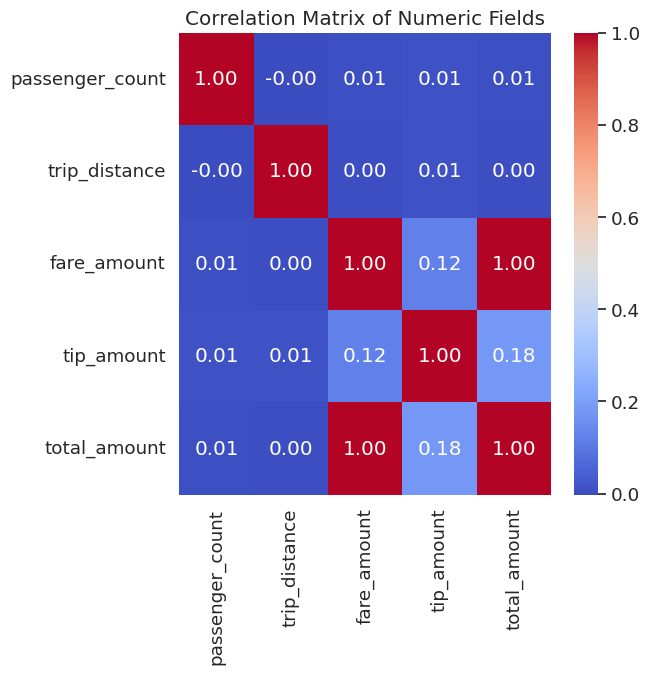

In [12]:
correlation_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols)

for col1 in numeric_cols:
    for col2 in numeric_cols:
        corr_value = df.stat.corr(col1, col2)
        correlation_matrix.loc[col1, col2] = corr_value

# Convert entries from object to float for plotting
correlation_matrix = correlation_matrix.astype(float)

# Plotting the correlation matrix
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numeric Fields')
plt.show()

In [13]:
# Most common values for categorical fields
categorical_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type']
for col_name in categorical_cols:
    df.groupBy(col_name).count().orderBy(desc("count")).show()

+--------+--------+
|VendorID|   count|
+--------+--------+
|       2|14242526|
|       1| 5245998|
|       6|    5096|
+--------+--------+

+----------+--------+
|RatecodeID|   count|
+----------+--------+
|       1.0|17925280|
|       2.0|  750333|
|      NULL|  528552|
|       5.0|   96844|
|      99.0|   95158|
|       3.0|   63642|
|       4.0|   33782|
|       6.0|      29|
+----------+--------+

+------------------+--------+
|store_and_fwd_flag|   count|
+------------------+--------+
|                 N|18854960|
|              NULL|  528552|
|                 Y|  110108|
+------------------+--------+

+------------+------+
|PULocationID| count|
+------------+------+
|         132|993524|
|         237|920499|
|         161|893743|
|         236|831315|
|         162|682956|
|         186|658093|
|         138|653381|
|         142|645180|
|         230|643242|
|         170|575098|
|         163|563951|
|         239|546406|
|          48|526753|
|         234|526540|
|        

## 1. Fare amount vs Tip Amount

In [14]:
# Sampling a fraction of the data for visualization
sampled_df = df.sample(fraction=0.15, withReplacement=False)

In [15]:
# Converting Spark DataFrame to Pandas DataFrame
pandas_df = sampled_df.select("fare_amount", "tip_amount").toPandas()

<Figure size 1200x600 with 0 Axes>

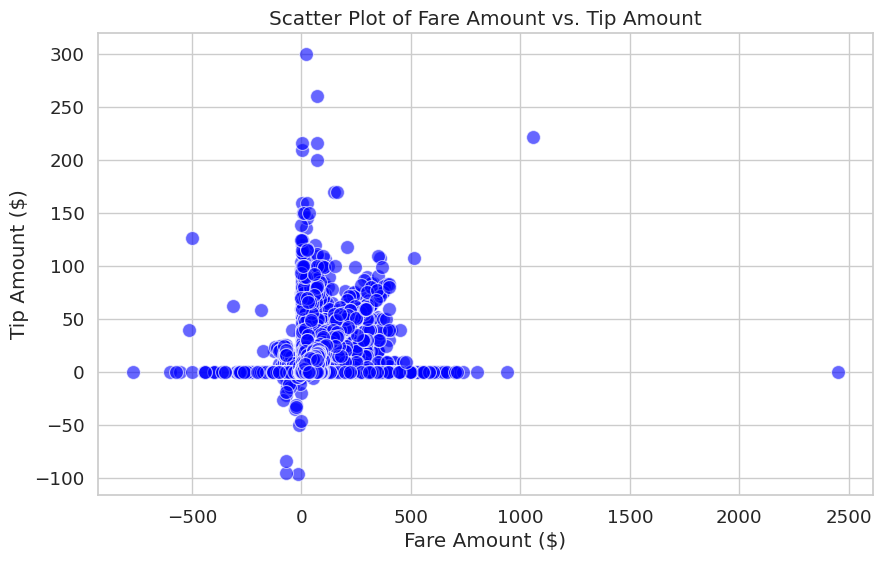

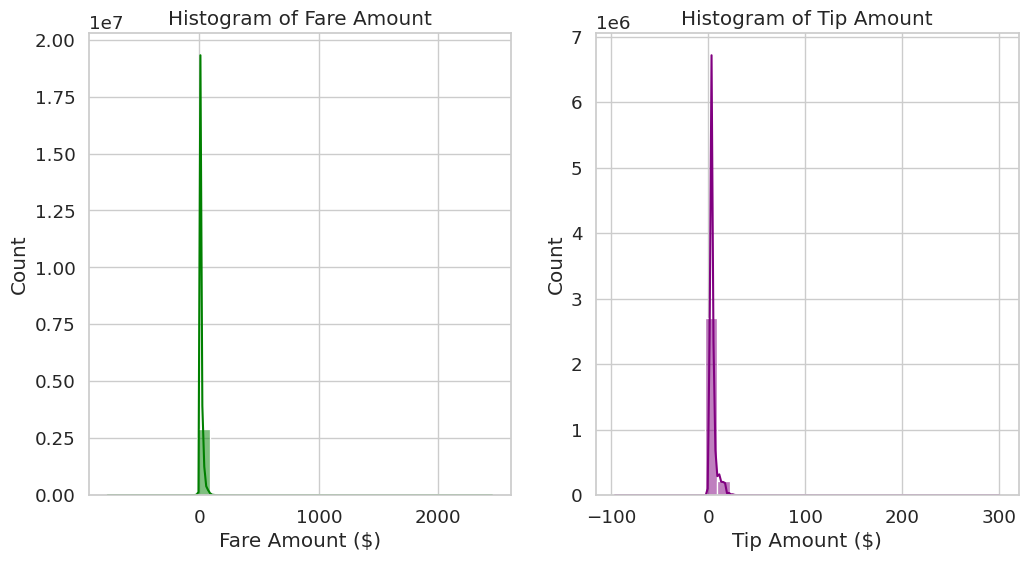

In [16]:
# Boxplot for fare_amount and tip_amount
plt.figure(figsize=(12, 6))

# Scatter plot to observe the relationship between fare amount and tip amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=pandas_df, color='blue', s=100, alpha=0.6)
plt.title('Scatter Plot of Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.show()

# Histograms to view the distributions of fare amount and tip amount
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(pandas_df['fare_amount'], kde=True, bins=30, color='green')
plt.title('Histogram of Fare Amount')
plt.xlabel('Fare Amount ($)')

plt.subplot(1, 2, 2)
sns.histplot(pandas_df['tip_amount'], kde=True, bins=30, color='purple')
plt.title('Histogram of Tip Amount')
plt.xlabel('Tip Amount ($)')
plt.show()

In [17]:
# Filter for negative fares and tips, group by payment type
negative_fares_tips = df.filter((col("fare_amount") < 0) | (col("tip_amount") < 0))
negative_fares_tips.groupBy("payment_type").count().show()

+------------+------+
|payment_type| count|
+------------+------+
|           0|  1735|
|           1|   115|
|           3| 30448|
|           2| 39393|
|           4|101340|
+------------+------+



In [18]:
# Group by RateCodeID for entries with negative fares or tips
negative_fares_tips.groupBy("RateCodeID").count().show()

+----------+------+
|RateCodeID| count|
+----------+------+
|      NULL|  1735|
|       1.0|153825|
|       4.0|   655|
|       3.0|  1890|
|       2.0| 11990|
|       5.0|  2936|
+----------+------+



In [19]:
# Extract year and month, then analyze counts of negative values
negative_fares_tips.withColumn("year", year("tpep_pickup_datetime")) \
    .withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("year", "month").count().orderBy("year", "month").show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2023|    1|25052|
|2023|    2|24773|
|2023|    3|29677|
|2023|    4|29989|
|2023|    5|32102|
|2023|    6|31438|
+----+-----+-----+

